In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('order_items.csv', 'order_items'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Yash@2002',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/OneDrive/Desktop/Ecommerce/archive (2)'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state            

In [1]:
pip install mysql-connector-python

   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.3 MB 326.8 kB/s eta 0:00:44
   ---------------------------------------- 0.2/14.3 MB 1.1 MB/s eta 0:00:14
   -- ------------------------------------- 0.8/14.3 MB 4.3 MB/s eta 0:00:04
   --- ------------------------------------ 1.4/14.3 MB 5.9 MB/s eta 0:00:03
   ----- ---------------------------------- 2.0/14.3 MB 7.0 MB/s eta 0:00:02
   ------- -------------------------------- 2.7/14.3 MB 8.1 MB/s eta 0:00:02
   -------- ------------------------------- 3.2/14.3 MB 8.4 MB/s eta 0:00:02
   --------- ------------------------------ 3.5/14.3 MB 9.0 MB/s eta 0:00:02
   ------------ --------------------------- 4.4/14.3 MB 9.6 MB/s eta 0:00:02
   -------------- ------------------------- 5.2/14.3 MB 10.0 MB/s eta 0:00:01
   --------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Yash@2002",
                            database = "ecommerce"
                            )

cur = db.cursor()

## Basic Queries

In [2]:
# 1. List all unique cities where customers are located.

query = """select distinct(customer_city) from customers"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns=["unique_cities"])
df.head()

,unique_cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [3]:
# 2. Count the number of orders placed in 2017.

query = """select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)

data = cur.fetchall()
print("Total orders placed in 2017 are:", data[0][0])

Total orders placed in 2017 are: 45101


In [4]:
# 3. Find the total sales per category.

query = """select products.product_category category, round(sum(payments.payment_value),2) sales 
from products join order_items 
on products.product_id = order_items.product_id 
join payments
on payments.order_id = order_items.order_id
group by product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","sales"])
df.head()

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


In [20]:
# 4. Calculate the percentage of orders that were paid in installments.

query = """select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments"""

cur.execute(query)

data = cur.fetchall()
print("the percentage of orders that were paid in installments:",data[0][0])

the percentage of orders that were paid in installments: 99.9981


   state  orders
0     SP   41746
1     SC    3637
2     MG   11635
3     PR    5045
4     RJ   12852
5     RS    5466
6     PA     975
7     GO    2020
8     ES    2033
9     BA    3380
10    MA     747
11    MS     715
12    CE    1336
13    DF    2140
14    RN     485
15    PE    1652
16    MT     907
17    AM     148
18    AP      68
19    AL     413
20    RO     253
21    PB     536
22    TO     280
23    PI     495
24    AC      81
25    SE     350
26    RR      46


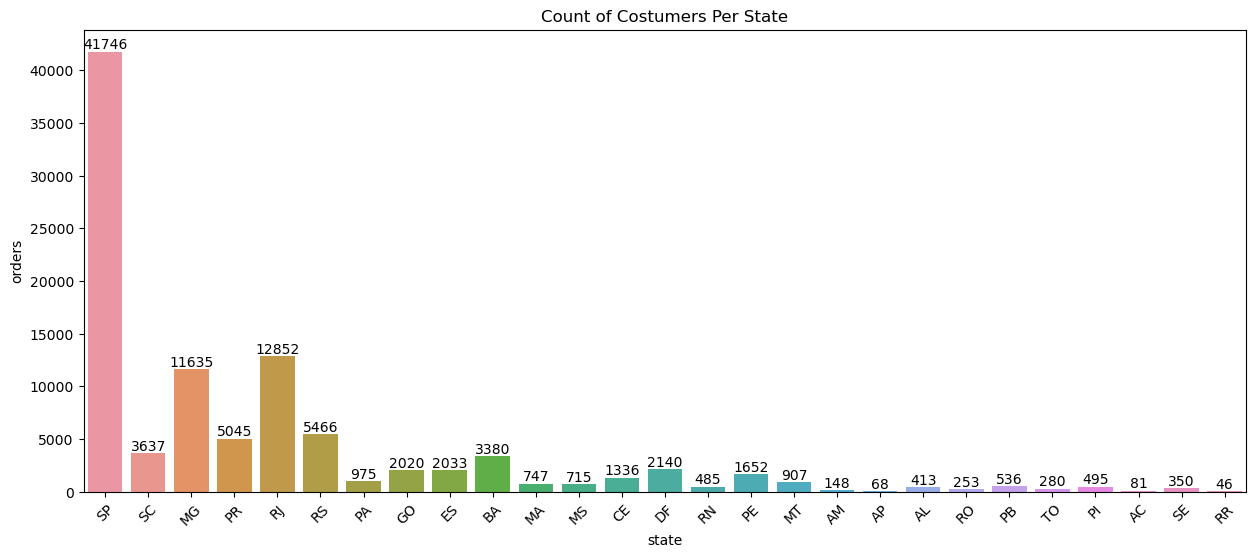

In [21]:
# 5. Count the number of customers from each state. 

query = """select customer_state, count(customer_id) from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["state","orders"])
print(df)


plt.figure(figsize=(15,6))
ax = sns.barplot(x=df['state'],y=df['orders'])
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title("Count of Costumers Per State")
plt.show()

## Intermediate Queries

      Months  Order_count
0       July         6292
1     August         6512
2   February         6728
3       June         6167
4      March         7211
5    January         7269
6        May         6873
7      April         6939
8  September           16
9    October            4


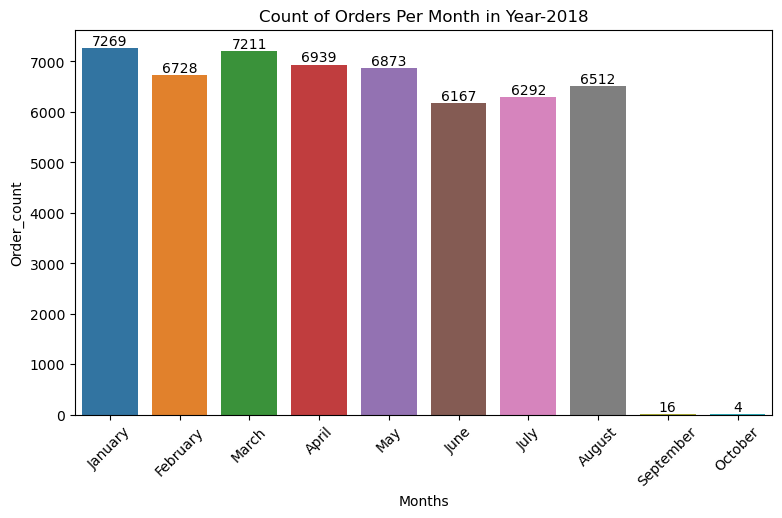

In [26]:
# 1. Calculate the number of orders per month in 2018.

query = """select monthname(order_purchase_timestamp) months,count(order_id) order_count 
from orders where year(order_purchase_timestamp)=2018
group by months"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns=["Months","Order_count"])
print(df)

o = ["January","February","March","April","May","June","July","August","September","October"]
plt.figure(figsize=(9,5))
ax = sns.barplot(x=df['Months'],y=df['Order_count'],order=o)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title('Count of Orders Per Month in Year-2018')
plt.show()

In [4]:
# 3. Calculate the percentage of total revenue contributed by each product category.

query = """select products.product_category category, 
round(sum(payments.payment_value)/(select sum(payment_value) from payments)*100,2) sales 
from products join order_items 
on products.product_id = order_items.product_id 
join payments
on payments.order_id = order_items.order_id
group by product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","sales_percentage"])
df.head()

,category,sales_percentage
0,perfumery,3.17
1,Furniture Decoration,8.93
2,telephony,3.04
3,bed table bath,10.70
4,automotive,5.32


In [15]:
# 4. Identify the correlation between product price and the number of times a product has been purchased.
import numpy as np
query = """select products.product_category, count(order_items.product_id), avg(order_items.price) 
from order_items join products
on order_items.product_id = products.product_id
group by products.product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category","Number of Products Purchased","Price"])

arr1 = df["Number of Products Purchased"]
arr2 = df["Price"]

a = np.corrcoef([arr1,arr2])
print("The correlation between the product price and the number of times product has been purchased: ",a[0][1])

The correlation between the product price and the number of times product has been purchased:  -0.10631552237549534


In [24]:
# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

query = """select *, dense_rank() over(order by rev desc) as rn from
(select sellers.seller_id, 
round(sum(payments.payment_value),2) rev 
from sellers join order_items 
on sellers.seller_id = order_items.seller_id 
join payments
on payments.order_id = order_items.order_id
group by sellers.seller_id) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_id","Sellers_Revenue","Rank"])
df.head()

,Seller_id,Sellers_Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


## Advanced Queries


In [28]:
# 1. Calculate the moving average of order values for each customer over their order history.

query = """select *,round(avg(payment) 
over(partition by customer_id order by 
order_purchase_timestamp 
rows between 2 preceding and current row),2) 
as mov_avg from
(select orders.customer_id,
orders.order_purchase_timestamp,
payments.payment_value as payment
from orders join payments 
on orders.order_id = payments.order_id) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_id","Order_Purchase_Timestamp","Payment_value","Mov_Avg"])
df.tail(10)

,Customer_id,Order_Purchase_Timestamp,Payment_value,Mov_Avg
103876,fffb97495f78be80e2759335275df2aa,2018-01-16 14:51:35,61.01,61.01
103877,fffc22669ca576ae3f654ea64c8f36be,2017-06-30 11:21:11,101.56,101.56
103878,fffcb937e9dd47a13f05ecb8290f4d3e,2018-03-17 00:55:27,91.91,91.91
103879,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,0.64
103880,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,9.49,5.06
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50
103885,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37


In [4]:
# 2. Calculate the cumulative sales per month for each year.

query = """select *, round(sum(payment) over(order by years,months),2) as cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from payments join orders
on payments.order_id = orders.order_id
group by years,months order by years,months) as a;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year","Month","Payment","Cumulative_sale"])
df

,Year,Month,Payment,Cumulative_sale
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


In [19]:
# 3. Calculate the year-over-year growth rate of total sales.

query = """select years,payment,
((payment - lag(payment,1) over(order by years))/lag(payment,1) over(order by years)) * 100
from (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from payments join orders
on payments.order_id = orders.order_id
group by years order by years) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['Year','Total_sale','growth_rate_%'])
df

,Year,Total_sale,growth_rate_%
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


In [21]:
# 5. Identify the top 3 customers who spent the most money in each year.

query = """select customer_id,years,payment,Ranking from
(select orders.customer_id, year(orders.order_purchase_timestamp) years, 
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as Ranking
from orders join payments on payments.order_id = orders.order_id
group by years,orders.customer_id) as a
where ranking <= 3;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['customer_id','Year','Total_payment','Rank'])
df

,customer_id,Year,Total_payment,Rank
0,a9dc96b027d1252bbac0a9b72d837fc6,2016,1423.550049,1
1,1d34ed25963d5aae4cf3d7f3a4cda173,2016,1400.739990,2
2,4a06381959b6670756de02e07b83815f,2016,1227.780029,3
3,1617b1357756262bfa56ab541c47bc16,2017,13664.080078,1
4,c6e2731c5b391845f6800c97401a43a9,2017,6929.310059,2
5,3fd6777bbce08a352fddd04e4a7cc8f6,2017,6726.660156,3
6,ec5b2ba62e574342386871631fafd3fc,2018,7274.879883,1
7,f48d464a0baaea338cb25f816991ab1f,2018,6922.209961,2
8,e0a2412720e9ea4f26c1ac985f6a7358,2018,4809.439941,3
